# Introduction to Quantitative Finance

Copyright (c) 2019 Python Charmers Pty Ltd, Australia, <https://pythoncharmers.com>. All rights reserved.

<img src="img/python_charmers_logo.png" width="300" alt="Python Charmers Logo">

Published under the Creative Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) license. See `LICENSE.md` for details.

Sponsored by Tibra Global Services, <https://tibra.com>

<img src="img/tibra_logo.png" width="300" alt="Tibra Logo">


## Module 1.2: Covariance and Correlation

### 1.2.3 Lagged Correlation /  Cross correlation


The correlation of two variables is an incredibly useful metric, however it has a severe limitation, particularly in many time series values.

We would investigate the correlation if we expect a causation (note that we cannot prove causation) between $X$ and $Y$, that is, we expect that if we change $X$ then we cause a change in $Y$. An example of such a hypothesis would be "if we spend more money on advertising, our sales will increase". We can affect advertising spend, which we assume in turn will cause an increase in sales.

However, the problem with determining this correlation is that advertising spend does not *immediately* affect sales. Instead, there is a period of time, a **lag**, between the spending and the sales increase. At the very least, people need time to get to the store!

Computing this **lagged correlation** is a normal task, and a common one when analysing time series data. Another phrase for this term is **cross-correlation**, with a lag $k$.

On terminology, if $X$ "happens first", we say it *leads* $Y$. If $Y$ "happens first", then $X$ *lags* $Y$. In many programming functions, the term used is simply "lag", and a negative lag value means a lead. Be careful with this though - some programs will only consider "lead", and positive values indicate this. Always check the documentation!

In [9]:
%run setup.ipy

### Investigating Cross Correlation

Let's have a look at an example. One might suspect that interest rate is a leading indicator of inflation. If interest rates are lower, then they spend more, leading to the inflation. 

<div class="alert alert-danger">
    In this section we will manually compute the lag and then the correlation. In practice, do not do this and see the next section for methods that do this for you. "Stand on the shoulders of giants", and tend to use existing libraries rather than rewriting core components of your program from scratch.
</div>

Let's look at some data:

In [10]:
import quandl
interest_rates = quandl.get("RBA/F13_FOOIRATCR")

In [11]:
interest_rates.columns = ["Cash Rate"]

<AxesSubplot:xlabel='Date'>

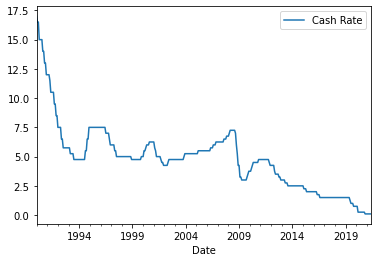

In [12]:
interest_rates.plot()

In [13]:
inflation = quandl.get("RBA/G01_GCPIAGSAQP")
inflation.columns = ['Inflation']

<AxesSubplot:xlabel='Date'>

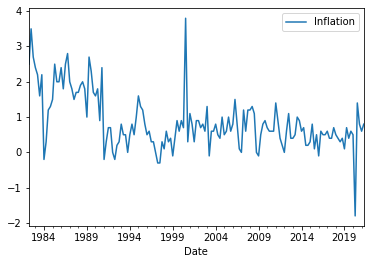

In [14]:
inflation.plot()

In [15]:
combined = inflation.join(interest_rates).dropna()  # Join by index, drop missing data

<AxesSubplot:xlabel='Date'>

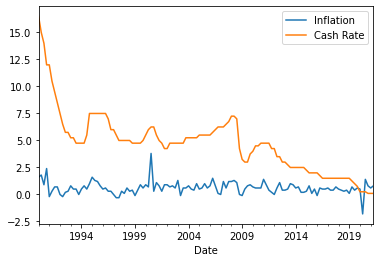

In [16]:
combined.plot()

Before we comput the correlation, we need to normalise. To do this, we will change the values from absolute values to the difference from the previous record:

In [17]:
combined = combined.pct_change()

<AxesSubplot:xlabel='Date'>

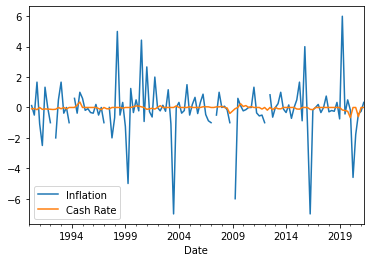

In [18]:
combined.plot()

Directly, the correlation is not that strong:

In [19]:
combined.corr().loc[('Cash Rate', "Inflation")]

0.024422232370015517

However, if we add a "lagged inflation" value, we get a stronger correlation:

In [20]:
combined['Lagged Inflation'] = combined['Inflation'].shift(2)

In [21]:
combined.head()

,Inflation,Cash Rate,Lagged Inflation
Date,,,
1990-03-31,NaN,NaN,NaN
1990-06-30,0.125000,-0.090909,NaN
1990-09-30,-0.500000,-0.066667,NaN
1990-12-31,1.666667,-0.142857,0.125
1991-03-31,-1.083333,0.000000,-0.500


In [22]:
combined.corr().loc[('Cash Rate', "Inflation")]

0.024422232370015517

In [23]:
combined.corr().loc[('Cash Rate', "Lagged Inflation")]  # Question - what does negative correlation mean?

-0.03506348228551407

<AxesSubplot:xlabel='Date'>

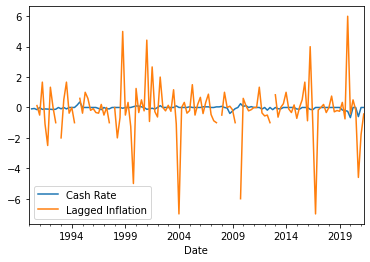

In [24]:
combined[['Cash Rate', 'Lagged Inflation']].plot()

Not only has the scale of the correlation increased, the sign has swapped! Note, if you choose different lag periods, you will get quite different answers. Further, the economy is much more complex than a single causal relationship - there will be other factors that alter impact of the Cash rate on the inflation, so it is not a single one-to-one relationship.

#### Exercise

Compute the following graph, which has the lag value as the x-axis, and the correlation as the y-axis.

<img src='img/lagged_correlation_plot.png'>

Note also that there is a spike in the -1 to -3 lag period - what does this mean?

Note that when you pull down your data, your time period will differ to the one used to create this image. Therefore, your results will vary, slightly, from mine. If you are unsure of your solution, rerun the provided solution for an "up to date" plot.

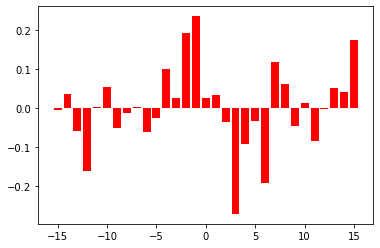

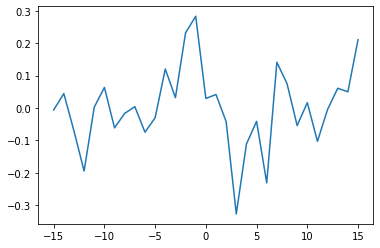

In [25]:
#Solution
lags = [i for i in range(-15,16)]
correlations = []


for lag in lags:
    temp = combined[['Cash Rate','Inflation']].copy()
    temp['lagged'] = temp['Inflation'].shift(lag)
    correlations.append(temp.corr().loc[('Cash Rate','lagged')])
correlations = np.array(correlations)

plt.bar(lags,correlations,color = 'red')
plt.show()
plt.plot(lags,correlations*1.2)


<BarContainer object of 31 artists>

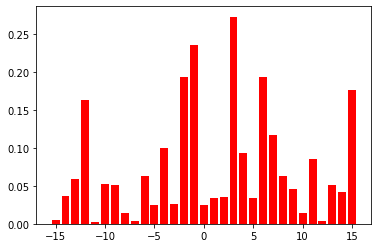

In [64]:
### negative correlations is also corrlations that we should concern. So an absolute value of correlation
### is also needed
abs_corr = [abs(ele) for ele in correlations]
plt.bar(lags,abs_corr,color = 'red')

*For solutions, see `solutions/lagged_correlations.py`*

### Computing Cross Correlation


In [28]:
import statsmodels.tsa.stattools as ts

In [29]:
combined.replace([np.inf, -np.inf], np.nan, inplace=True)

In [30]:
combined.dropna(inplace=True)

In [31]:
combined.head()

,Inflation,Cash Rate,Lagged Inflation
Date,,,
1990-12-31,1.666667,-0.142857,0.125000
1991-03-31,-1.083333,0.000000,-0.500000
1991-06-30,-2.500000,-0.125000,1.666667
1991-09-30,1.333333,-0.095238,-1.083333
1991-12-31,0.000000,-0.105263,-2.500000


In [32]:
ccf = ts.ccf(combined['Cash Rate'], combined['Inflation'])

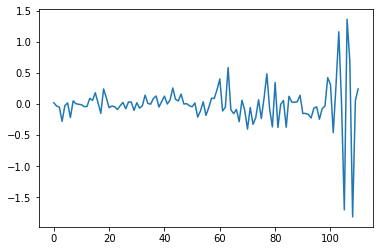

In [33]:
plt.plot(ccf)

A good rule of thumb is that a correlation is significant if it is higher than $\frac{2}{\sqrt{n - |k|}}$, where $n$ is the number of datapoints, and $|k|$ is the lag:

(-1.0, 1.0)

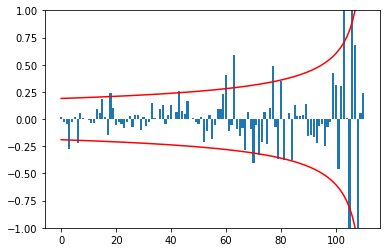

In [34]:
n = len(combined)
x = np.arange(0, n)
threshold_positive = 2 / np.sqrt(n - x)
threshold_negative = 2 / -np.sqrt(n - x)

plt.bar(x,ccf)
plt.plot(threshold_positive, 'r')
plt.plot(threshold_negative, 'r')
plt.ylim(-1, 1)

We can see "significant" peaks at 20, 36 and 40. I put significant in quotes here - this is just a rule of thumb, and should be tested more robustly. Further, we haven't checked our assumptions about the data that are necessary for such a test.

In [35]:
np.where(ccf > threshold_positive)[0]  # np.where tells us the index where a test is true.

array([ 18,  43,  60,  63,  77, 103, 106])

In [36]:
np.where(ccf < threshold_negative)[0]

array([  3,   6,  70,  72,  79,  81, 105, 108])

### Requirements and assumptions

Cross correlation tests have important assumptions that must be adhered to.

* No autocorrelation
* Time series are stationarity

We will examine both of these concepts, and how to test for them.

### Autocorrelation

Autocorrelation is the rate at which a series of data (usually time series) correlates with itself (specifically, itself with lag). An example of this is a time series where one value is dependent on the previous version:

In [37]:
# Here is a completely random series, it should not depend on itself, and therefore should not have any autocorrelation
random_values = [0]

for i in range(100):
    # Just a random value
    random_values.append(np.random.random() - 0.5)

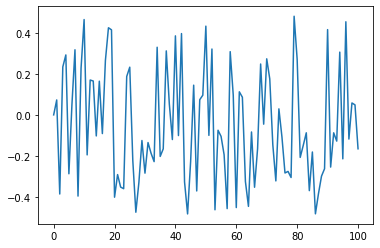

In [38]:
plt.plot(random_values)

/Users/yudizhou/opt/anaconda3/envs/tens/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/Users/yudizhou/opt/anaconda3/envs/tens/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


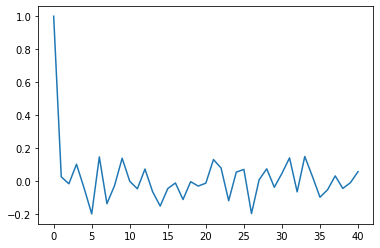

In [39]:
# Compute autocorrelation values, which are the correlation of x with itself, lagged
plt.plot(ts.acf(random_values))

In the above graph, we see the values correlate exactly with itself with no lag - unsurprising!

However, after this, any other lag value has a near-zero correlation, indicating no correlation between the values and the lagged version.

Let's now create a time series with dependency.

In [40]:
# Here is an example where value (n) is dependent on value (n-1)
values = [0]

for i in range(100):
    # Add a random value to the previous value. While the values are random, they are random, but biased
    values.append(np.random.random() - 0.5 + values[-1])

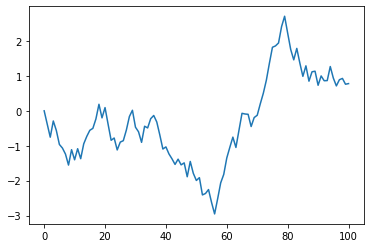

In [41]:
plt.plot(values)

/Users/yudizhou/opt/anaconda3/envs/tens/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


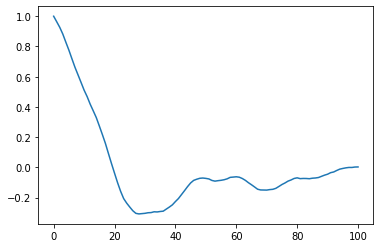

In [42]:
plt.plot(ts.acf(values, nlags=100))

In this example, the values are correlated with itself (as per the definition of correlation), but the correlation stays high as the lag increases. This shows that the values are dependent on themselves.

If your data is autocorrelated, you should remove this before computing cross correlation with other time series. You can remove autocorrelation with a process known as pre-whitening, which removes the autocorrelation.

An example of a method for this is Holt Winters. Techniques like this are also known as smoothing algorithms, but that term has multiple meanings, and smoothing algorithms have multiple uses.

In [43]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [44]:
model = SimpleExpSmoothing(values)

/Users/yudizhou/opt/anaconda3/envs/tens/lib/python3.6/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [45]:
model_fit = model.fit()

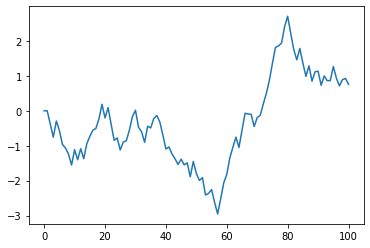

In [46]:
plt.plot(model_fit.fittedvalues)

/Users/yudizhou/opt/anaconda3/envs/tens/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


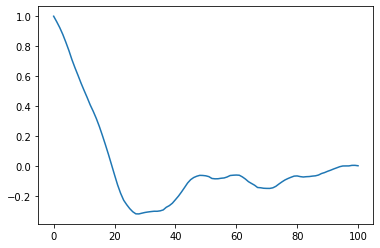

In [47]:
plt.plot(ts.acf(model_fit.fittedvalues, nlags=100))

#### Exercises

1. Review the documentation on the Smoothing algorithms from https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html See also the "Next" link to the left to view more algorithms.
2. Check the autocorrelation for two currencies from Quandl (try the BUNDESBANK data source)
3. Using a smoothing (whitening) algorithm, smooth the values of those currencies and check for autocorrelations in the results

In [54]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
cur1 = quandl.get("BUNDESBANK/BBEX3_D_ARS_USD_CA_AC_000")
cur1 = cur1['Value']
cur1.name = "ARS"
model1 = ExponentialSmoothing(cur1)
res1 = model1.fit()
cur2 = quandl.get("BUNDESBANK/BBEX3_M_SDG_USD_CA_AA_A01")
cur2 = cur2['Value']
cur2.name = "SDG"
model2 = ExponentialSmoothing(cur2)
res2 = model2.fit()
plt.plot(ts.acf(res1.fittedvalues, nlags=200))
plt.plot(ts.acf(res2.fittedvalues, nlags=200))
plt.legend()

LimitExceededError: (Status 429) (Quandl Error QELx01) You have exceeded the anonymous user limit of 50 calls per day. To make more calls today, please register for a free Nasdaq Data Link account and then include your API key with your requests.

*For solutions, see `solutions/exponential_smoothing.py`*

### Stationarity

A stationary dataset is one where the main statistics are consistent throughout the given data, usually the mean and standard deviation. For instance, a time series with inflation would not be stationary, as it tends to grow overtime:

In [102]:
import quandl

In [103]:
platinum_prices = quandl.get("LPPM/PLAT")['USD AM']

<AxesSubplot:xlabel='Date'>

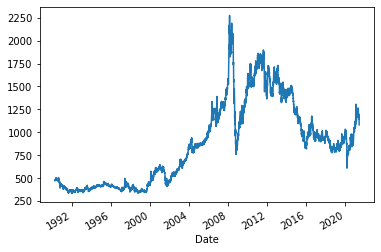

In [104]:
platinum_prices.plot()

If we plot the moving average, we can see it tends to increase:

<AxesSubplot:xlabel='Date'>

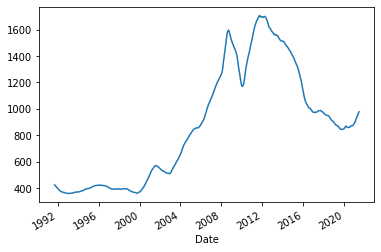

In [105]:
platinum_prices.rolling(365).mean().dropna().plot()  # Rolling n day window

We can see here that the mean is not consistent over time. This data is not stationary, which we can test more formally:

In [106]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(platinum_prices)
print('ADF Statistic: {:.2f}'.format(result[0]))
print('p-value: {:.2f}'.format(result[1]))

ADF Statistic: -1.67
p-value: 0.45


If the p-value is less than a given threshold (for instance 0.05) we would reject the hypothesis of a "unit root" and declare the dataset as stationary. Let's do the same test with our random values from before

In [107]:
result = adfuller(random_values)
print('ADF Statistic: {:.2f}'.format(result[0]))
print('p-value: {:.2f}'.format(result[1]))

ADF Statistic: -3.55
p-value: 0.01


We can see here a p-value of (near) zero, which we would expect in this data as it has no time dependent structure.

#### Exercises

1. Compute the `adfuller` statistic for the currencies you extracted from Quandl earlier.
2. A simple method of transforming data to be stationary is to compute the difference to the previous value. Difference your data to obtain a stationary dataset.
3. Another method to create stationary data is transform the data using a log function. Compute the log of the currencies and recompute the adfuller statistic.

*For solutions, see `solutions/adfuller.py`*

### CAPM - Capital Asset Pricing Model

The CAPM model is a widely used model to determine expected returns for an asset and the impact of systematic risk. One method for calculating systematic risk is to measure the correlation between a stock and the market in general.

The CAPM model is:


$ \bar{R_a} = R_f + \beta (\bar{R_m} - R_f)$

Where:

* $\bar{R_a}$ is the expected return of the investment
* $R_f$ is the risk free rate
* $\beta$ is the Beta of the investment (see below)
* $\bar{R_m}$ is the expected return of the market

Note that the value $(\bar{R_m} - R_f)$ is also known as the market risk premium.

The Beta of an investment is the volatility of the stock, in relation to the market. If the stock moves with the market, it has a Beta around 1.0 (the market itself has, by definition, a Beta of 1.0). Stocks with low Beta values have less risk. High Beta values have high risk.

To compute Beta, the equation is:

$\beta = \frac{cov(a, m)}{var(m)}$

Where $var(m)$ is the variance of the market, and $cov(a, m)$ is the covariance between the market and the given asset.

#### Extended Exercise

1. Download the S&P 500 data from Quandl. Use the dataset search to find an appropriate data source.
2. Compute the percentage change on a daily basis as a value between 0 and 100% - not a decimal. You'll need the closing price.
3. Repeat steps 1 and 2 for a given stock (the provided solution uses Coca Cola)
4. Compute the Beta value, using the prices for the period 2016 to 2018 inclusive
5. Compute the CAPM value, with a risk free rate of 2.5% (or another if you have a preferred risk free investment). Hint: CAGR

*For solutions, see `solutions/capm.py`*